In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import io
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm 
from skimage.metrics import structural_similarity as ssim
import lpips 
from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import save_image
import random

## Preprocessing

In [2]:
dataset_path1 = '/home/gsalsabil2/deep_learning/no_augment_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [3]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [4]:
batch_size = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [5]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['240.png', '690.png', '770.png', '175.png', '247.png', '709.png', '600.png', '238.png']
High resolution file name: ['240.png', '690.png', '770.png', '175.png', '247.png', '709.png', '600.png', '238.png']


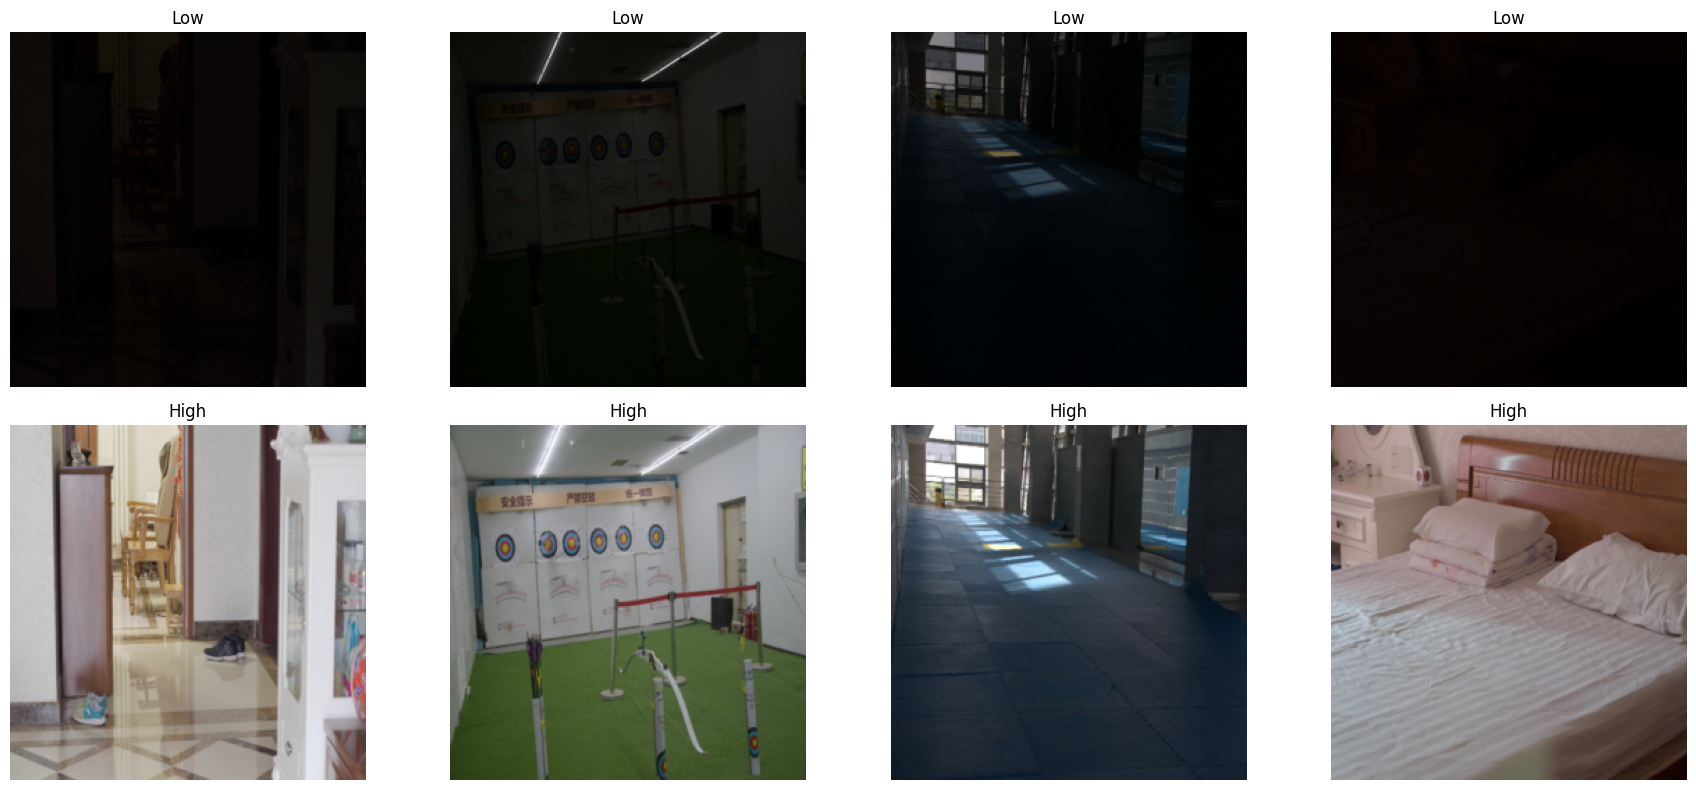

In [6]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

## Model Architecture

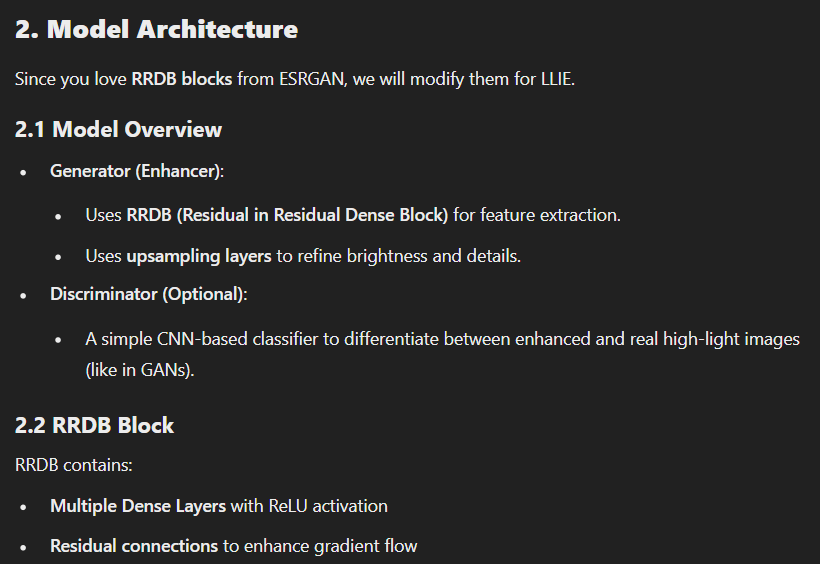

In [7]:
## RRDB blocks architecture derived from the paper ESRGAN..

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels=64, growth_rate=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_rate, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out1 = torch.relu(self.conv1(x))
        out2 = torch.relu(self.conv2(torch.cat([x, out1], dim=1)))
        out3 = self.conv3(torch.cat([x, out1, out2], dim=1))
        return x + out3

class RRDB(nn.Module):
    def __init__(self, in_channels=64, beta=0.2):  
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(in_channels)
        self.rdb2 = ResidualDenseBlock(in_channels)
        self.rdb3 = ResidualDenseBlock(in_channels)
        self.beta = beta  # Scaling factor for residual

    def forward(self, x):
        residual = self.rdb3(self.rdb2(self.rdb1(x)))
        return x + self.beta * residual  # Scaled residual for stability

In [8]:
class Generator(nn.Module):
    def __init__(self, num_rrdb=6):
        super(Generator, self).__init__()

        # Initial feature extraction
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # RRDB Blocks
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])

        # Global Residual Path (helps learn overall brightness correction)
        self.global_residual = nn.Conv2d(3, 3, kernel_size=3, padding=1)

        # Final convolution layers for reconstruction
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        initial_features = self.initial_conv(x)
        enhanced_features = self.rrdb_blocks(initial_features)
        reconstructed = self.final_conv(enhanced_features)
        
        # Adding the global residual path
        output = reconstructed + self.global_residual(x)
        
        return torch.sigmoid(output)  # Normalize output to [0,1]

In [9]:
'''  Use a Discriminator (GAN Approach)
        This makes the enhanced image look more realistic by forcing the Generator to fool a Discriminator.
        USES PatchGANDiscriminator idea as the Discriminator'''

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, num_filters=64, num_layers=3):
        super(PatchGANDiscriminator, self).__init__()
        
        # Initial convolutional layer
        layers = [
            nn.Conv2d(in_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Intermediate convolutional layers
        for i in range(1, num_layers):
            layers += [
                nn.Conv2d(num_filters * (2 ** (i - 1)), num_filters * (2 ** i), kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(num_filters * (2 ** i)),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        
        # Final convolutional layer
        layers += [
            nn.Conv2d(num_filters * (2 ** (num_layers - 1)), 1, kernel_size=4, stride=1, padding=1)
        ]
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Output shape: [batch_size, 1, H, W]

In [10]:
## Loss Functions

# L1 Loss (Pixel-Level Difference)
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)

# Perceptual Loss using VGG-19 Features
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]  # Use first few layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG model
        self.vgg = vgg.eval()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.criterion(x_features, y_features)

In [11]:
## Common evaluating Metrics
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

# Initialize models and losses
generator = Generator().to(device)
discriminator = PatchGANDiscriminator().to(device)
opt_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr = 4e-4, betas=(0.5, 0.999))

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

/home/gsalsabil2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated

In [12]:
def validate(generator, val_loader, epoch):
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0, 'val_loss': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Validation loss (L1 + perceptual)
            loss = (10 * F.l1_loss(fake, high) + 0.1 * criterion_perceptual(fake, high)).item()
            
            # Update metrics
            val_metrics['val_loss'] += loss
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    for k in val_metrics:
        val_metrics[k] /= len(val_loader)
    return val_metrics

Source: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

In [13]:
def compute_gradient_penalty(disc, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = disc(interpolates)
    fake = torch.ones_like(d_interpolates)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [14]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="NOAUG_RRDB_CHECKPOINTS"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_psnr=0
    best_lpips=100

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)
            
            gp = compute_gradient_penalty(discriminator, high.data, fake.data)
            d_loss = (real_loss + fake_loss) / 2+ 10*gp
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 10
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [15]:
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|██████████| 49/49 [00:26<00:00,  1.82it/s, D_loss=86.423, G_loss=2.656, L1=1.890]   



Validation @ Epoch 1:
PSNR: 15.13 dB | SSIM: 0.6187 | LPIPS: 0.4691
🔥 New best model (PSNR: 15.1282 | LPIPS: 0.4691 | SSIM: 0.6187) saved!
🔥 New best model (LPIPS: 0.4691 | SSIM: 0.6187) saved!
🔥 New best model (PSNR: 15.1282 | SSIM: 0.6187) saved!
🔥 New best model (PSNR: 15.1282 | LPIPS: 0.4691) saved!
🔥 New best model (SSIM: 0.6187) saved!
🔥 New best model (PSNR: 15.1282) saved!
🔥 New best model (LPIPS: 0.4691) saved!


Epoch 2/200: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s, D_loss=58.009, G_loss=2.145, L1=1.377] 



Validation @ Epoch 2:
PSNR: 15.82 dB | SSIM: 0.6614 | LPIPS: 0.4204
🔥 New best model (PSNR: 15.8235 | LPIPS: 0.4204 | SSIM: 0.6614) saved!
🔥 New best model (LPIPS: 0.4204 | SSIM: 0.6614) saved!
🔥 New best model (PSNR: 15.8235 | SSIM: 0.6614) saved!
🔥 New best model (PSNR: 15.8235 | LPIPS: 0.4204) saved!
🔥 New best model (SSIM: 0.6614) saved!
🔥 New best model (PSNR: 15.8235) saved!
🔥 New best model (LPIPS: 0.4204) saved!


Epoch 3/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=5.484, G_loss=1.805, L1=1.043] 



Validation @ Epoch 3:
PSNR: 15.85 dB | SSIM: 0.6899 | LPIPS: 0.3919
🔥 New best model (PSNR: 15.8524 | LPIPS: 0.3919 | SSIM: 0.6899) saved!
🔥 New best model (LPIPS: 0.3919 | SSIM: 0.6899) saved!
🔥 New best model (PSNR: 15.8524 | SSIM: 0.6899) saved!
🔥 New best model (PSNR: 15.8524 | LPIPS: 0.3919) saved!
🔥 New best model (SSIM: 0.6899) saved!
🔥 New best model (PSNR: 15.8524) saved!
🔥 New best model (LPIPS: 0.3919) saved!


Epoch 4/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=23.316, G_loss=2.369, L1=1.607] 



Validation @ Epoch 4:
PSNR: 15.95 dB | SSIM: 0.7194 | LPIPS: 0.3449
🔥 New best model (PSNR: 15.9525 | LPIPS: 0.3449 | SSIM: 0.7194) saved!
🔥 New best model (LPIPS: 0.3449 | SSIM: 0.7194) saved!
🔥 New best model (PSNR: 15.9525 | SSIM: 0.7194) saved!
🔥 New best model (PSNR: 15.9525 | LPIPS: 0.3449) saved!
🔥 New best model (SSIM: 0.7194) saved!
🔥 New best model (PSNR: 15.9525) saved!
🔥 New best model (LPIPS: 0.3449) saved!


Epoch 5/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=11.565, G_loss=2.040, L1=1.281]



Validation @ Epoch 5:
PSNR: 15.45 dB | SSIM: 0.7156 | LPIPS: 0.3368
🔥 New best model (LPIPS: 0.3368) saved!


Epoch 6/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=4.196, G_loss=2.629, L1=1.871] 



Validation @ Epoch 6:
PSNR: 16.24 dB | SSIM: 0.7510 | LPIPS: 0.3144
🔥 New best model (PSNR: 16.2396 | LPIPS: 0.3144 | SSIM: 0.7510) saved!
🔥 New best model (LPIPS: 0.3144 | SSIM: 0.7510) saved!
🔥 New best model (PSNR: 16.2396 | SSIM: 0.7510) saved!
🔥 New best model (PSNR: 16.2396 | LPIPS: 0.3144) saved!
🔥 New best model (SSIM: 0.7510) saved!
🔥 New best model (PSNR: 16.2396) saved!
🔥 New best model (LPIPS: 0.3144) saved!


Epoch 7/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=47.664, G_loss=2.850, L1=2.097]



Validation @ Epoch 7:
PSNR: 15.73 dB | SSIM: 0.7463 | LPIPS: 0.3196


Epoch 8/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=11.590, G_loss=2.167, L1=1.412]



Validation @ Epoch 8:
PSNR: 16.11 dB | SSIM: 0.7506 | LPIPS: 0.3076
🔥 New best model (LPIPS: 0.3076) saved!


Epoch 9/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=5.200, G_loss=1.916, L1=1.164] 



Validation @ Epoch 9:
PSNR: 15.97 dB | SSIM: 0.7465 | LPIPS: 0.3138


Epoch 10/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.414, G_loss=2.463, L1=1.724] 



Validation @ Epoch 10:
PSNR: 16.57 dB | SSIM: 0.7783 | LPIPS: 0.2901
🔥 New best model (PSNR: 16.5678 | LPIPS: 0.2901 | SSIM: 0.7783) saved!
🔥 New best model (LPIPS: 0.2901 | SSIM: 0.7783) saved!
🔥 New best model (PSNR: 16.5678 | SSIM: 0.7783) saved!
🔥 New best model (PSNR: 16.5678 | LPIPS: 0.2901) saved!
🔥 New best model (SSIM: 0.7783) saved!
🔥 New best model (PSNR: 16.5678) saved!
🔥 New best model (LPIPS: 0.2901) saved!


Epoch 11/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.437, G_loss=2.041, L1=1.297] 



Validation @ Epoch 11:
PSNR: 16.16 dB | SSIM: 0.7737 | LPIPS: 0.2922


Epoch 12/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.257, G_loss=1.487, L1=0.748] 



Validation @ Epoch 12:
PSNR: 16.92 dB | SSIM: 0.7842 | LPIPS: 0.2938
🔥 New best model (PSNR: 16.9218 | SSIM: 0.7842) saved!
🔥 New best model (SSIM: 0.7842) saved!
🔥 New best model (PSNR: 16.9218) saved!


Epoch 13/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.400, G_loss=1.801, L1=1.054] 



Validation @ Epoch 13:
PSNR: 17.01 dB | SSIM: 0.7890 | LPIPS: 0.2740
🔥 New best model (PSNR: 17.0126 | LPIPS: 0.2740 | SSIM: 0.7890) saved!
🔥 New best model (LPIPS: 0.2740 | SSIM: 0.7890) saved!
🔥 New best model (PSNR: 17.0126 | SSIM: 0.7890) saved!
🔥 New best model (PSNR: 17.0126 | LPIPS: 0.2740) saved!
🔥 New best model (SSIM: 0.7890) saved!
🔥 New best model (PSNR: 17.0126) saved!
🔥 New best model (LPIPS: 0.2740) saved!


Epoch 14/200: 100%|██████████| 49/49 [00:28<00:00,  1.70it/s, D_loss=1.481, G_loss=1.868, L1=1.125] 



Validation @ Epoch 14:
PSNR: 16.67 dB | SSIM: 0.7929 | LPIPS: 0.2841
🔥 New best model (SSIM: 0.7929) saved!


Epoch 15/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=2.154, G_loss=2.124, L1=1.379]



Validation @ Epoch 15:
PSNR: 16.48 dB | SSIM: 0.7911 | LPIPS: 0.2760


Epoch 16/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.110, G_loss=1.971, L1=1.223]



Validation @ Epoch 16:
PSNR: 16.32 dB | SSIM: 0.7790 | LPIPS: 0.2789


Epoch 17/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.254, G_loss=1.598, L1=0.859] 



Validation @ Epoch 17:
PSNR: 16.49 dB | SSIM: 0.7831 | LPIPS: 0.2829


Epoch 18/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.945, G_loss=2.183, L1=1.447] 



Validation @ Epoch 18:
PSNR: 16.27 dB | SSIM: 0.7851 | LPIPS: 0.2787


Epoch 19/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.430, G_loss=2.249, L1=1.508] 



Validation @ Epoch 19:
PSNR: 16.90 dB | SSIM: 0.8011 | LPIPS: 0.2618
🔥 New best model (LPIPS: 0.2618 | SSIM: 0.8011) saved!
🔥 New best model (SSIM: 0.8011) saved!
🔥 New best model (LPIPS: 0.2618) saved!


Epoch 20/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.882, G_loss=1.599, L1=0.860] 



Validation @ Epoch 20:
PSNR: 17.03 dB | SSIM: 0.8051 | LPIPS: 0.2491
🔥 New best model (PSNR: 17.0298 | LPIPS: 0.2491 | SSIM: 0.8051) saved!
🔥 New best model (LPIPS: 0.2491 | SSIM: 0.8051) saved!
🔥 New best model (PSNR: 17.0298 | SSIM: 0.8051) saved!
🔥 New best model (PSNR: 17.0298 | LPIPS: 0.2491) saved!
🔥 New best model (SSIM: 0.8051) saved!
🔥 New best model (PSNR: 17.0298) saved!
🔥 New best model (LPIPS: 0.2491) saved!


Epoch 21/200: 100%|██████████| 49/49 [00:28<00:00,  1.71it/s, D_loss=1.508, G_loss=1.703, L1=0.961] 



Validation @ Epoch 21:
PSNR: 17.09 dB | SSIM: 0.8082 | LPIPS: 0.2561
🔥 New best model (PSNR: 17.0888 | SSIM: 0.8082) saved!
🔥 New best model (SSIM: 0.8082) saved!
🔥 New best model (PSNR: 17.0888) saved!


Epoch 22/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=12.847, G_loss=2.523, L1=1.776]



Validation @ Epoch 22:
PSNR: 16.68 dB | SSIM: 0.7998 | LPIPS: 0.2688


Epoch 23/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.816, G_loss=2.399, L1=1.642] 



Validation @ Epoch 23:
PSNR: 16.48 dB | SSIM: 0.7959 | LPIPS: 0.2545


Epoch 24/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=1.662, G_loss=2.137, L1=1.390]



Validation @ Epoch 24:
PSNR: 16.81 dB | SSIM: 0.7841 | LPIPS: 0.2635


Epoch 25/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.801, G_loss=2.291, L1=1.555]



Validation @ Epoch 25:
PSNR: 16.93 dB | SSIM: 0.8101 | LPIPS: 0.2587
🔥 New best model (SSIM: 0.8101) saved!


Epoch 26/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.773, G_loss=1.724, L1=0.997]



Validation @ Epoch 26:
PSNR: 17.01 dB | SSIM: 0.8147 | LPIPS: 0.2472
🔥 New best model (LPIPS: 0.2472 | SSIM: 0.8147) saved!
🔥 New best model (SSIM: 0.8147) saved!
🔥 New best model (LPIPS: 0.2472) saved!


Epoch 27/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.192, G_loss=1.765, L1=1.034]



Validation @ Epoch 27:
PSNR: 16.90 dB | SSIM: 0.8056 | LPIPS: 0.2503


Epoch 28/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.988, G_loss=1.997, L1=1.261]



Validation @ Epoch 28:
PSNR: 16.94 dB | SSIM: 0.7985 | LPIPS: 0.2603


Epoch 29/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=2.356, G_loss=2.671, L1=1.929]



Validation @ Epoch 29:
PSNR: 16.44 dB | SSIM: 0.8064 | LPIPS: 0.2545


Epoch 30/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.084, G_loss=1.630, L1=0.902]



Validation @ Epoch 30:
PSNR: 17.11 dB | SSIM: 0.8186 | LPIPS: 0.2452
🔥 New best model (PSNR: 17.1078 | LPIPS: 0.2452 | SSIM: 0.8186) saved!
🔥 New best model (LPIPS: 0.2452 | SSIM: 0.8186) saved!
🔥 New best model (PSNR: 17.1078 | SSIM: 0.8186) saved!
🔥 New best model (PSNR: 17.1078 | LPIPS: 0.2452) saved!
🔥 New best model (SSIM: 0.8186) saved!
🔥 New best model (PSNR: 17.1078) saved!
🔥 New best model (LPIPS: 0.2452) saved!


Epoch 31/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.822, G_loss=1.717, L1=0.986]



Validation @ Epoch 31:
PSNR: 17.00 dB | SSIM: 0.8172 | LPIPS: 0.2432
🔥 New best model (LPIPS: 0.2432) saved!


Epoch 32/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.126, G_loss=1.956, L1=1.219]



Validation @ Epoch 32:
PSNR: 17.33 dB | SSIM: 0.8204 | LPIPS: 0.2409
🔥 New best model (PSNR: 17.3257 | LPIPS: 0.2409 | SSIM: 0.8204) saved!
🔥 New best model (LPIPS: 0.2409 | SSIM: 0.8204) saved!
🔥 New best model (PSNR: 17.3257 | SSIM: 0.8204) saved!
🔥 New best model (PSNR: 17.3257 | LPIPS: 0.2409) saved!
🔥 New best model (SSIM: 0.8204) saved!
🔥 New best model (PSNR: 17.3257) saved!
🔥 New best model (LPIPS: 0.2409) saved!


Epoch 33/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.847, G_loss=1.708, L1=0.977]



Validation @ Epoch 33:
PSNR: 16.73 dB | SSIM: 0.8138 | LPIPS: 0.2471


Epoch 34/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.172, G_loss=2.369, L1=1.637]



Validation @ Epoch 34:
PSNR: 16.64 dB | SSIM: 0.8092 | LPIPS: 0.2421


Epoch 35/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.096, G_loss=1.977, L1=1.242]



Validation @ Epoch 35:
PSNR: 17.10 dB | SSIM: 0.8179 | LPIPS: 0.2386
🔥 New best model (LPIPS: 0.2386) saved!


Epoch 36/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.767, G_loss=2.061, L1=1.324]



Validation @ Epoch 36:
PSNR: 17.07 dB | SSIM: 0.8200 | LPIPS: 0.2342
🔥 New best model (LPIPS: 0.2342) saved!


Epoch 37/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.430, G_loss=1.984, L1=1.253]



Validation @ Epoch 37:
PSNR: 17.17 dB | SSIM: 0.8191 | LPIPS: 0.2463


Epoch 38/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.803, G_loss=2.297, L1=1.564]



Validation @ Epoch 38:
PSNR: 16.72 dB | SSIM: 0.8111 | LPIPS: 0.2318
🔥 New best model (LPIPS: 0.2318) saved!


Epoch 39/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.915, G_loss=1.725, L1=0.991]



Validation @ Epoch 39:
PSNR: 17.02 dB | SSIM: 0.8183 | LPIPS: 0.2459


Epoch 40/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.910, G_loss=1.480, L1=0.745]



Validation @ Epoch 40:
PSNR: 17.48 dB | SSIM: 0.8276 | LPIPS: 0.2326
🔥 New best model (PSNR: 17.4845 | SSIM: 0.8276) saved!
🔥 New best model (SSIM: 0.8276) saved!
🔥 New best model (PSNR: 17.4845) saved!


Epoch 41/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=1.028, G_loss=2.712, L1=1.978]



Validation @ Epoch 41:
PSNR: 17.39 dB | SSIM: 0.8268 | LPIPS: 0.2259
🔥 New best model (LPIPS: 0.2259) saved!


Epoch 42/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.945, G_loss=2.290, L1=1.555]



Validation @ Epoch 42:
PSNR: 16.82 dB | SSIM: 0.8167 | LPIPS: 0.2308


Epoch 43/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.993, G_loss=1.906, L1=1.169]



Validation @ Epoch 43:
PSNR: 17.40 dB | SSIM: 0.8270 | LPIPS: 0.2395


Epoch 44/200: 100%|██████████| 49/49 [00:28<00:00,  1.71it/s, D_loss=0.791, G_loss=2.761, L1=2.021]



Validation @ Epoch 44:
PSNR: 16.65 dB | SSIM: 0.8224 | LPIPS: 0.2265


Epoch 45/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.190, G_loss=1.753, L1=1.020]



Validation @ Epoch 45:
PSNR: 17.31 dB | SSIM: 0.8310 | LPIPS: 0.2261
🔥 New best model (SSIM: 0.8310) saved!


Epoch 46/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.722, G_loss=1.689, L1=0.958]



Validation @ Epoch 46:
PSNR: 16.76 dB | SSIM: 0.8168 | LPIPS: 0.2260


Epoch 47/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.567, G_loss=1.588, L1=0.838]



Validation @ Epoch 47:
PSNR: 17.44 dB | SSIM: 0.8270 | LPIPS: 0.2367


Epoch 48/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.165, G_loss=1.665, L1=0.929]



Validation @ Epoch 48:
PSNR: 17.45 dB | SSIM: 0.8183 | LPIPS: 0.2309


Epoch 49/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.798, G_loss=1.679, L1=0.952]



Validation @ Epoch 49:
PSNR: 17.10 dB | SSIM: 0.8274 | LPIPS: 0.2355


Epoch 50/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.797, G_loss=1.611, L1=0.882]



Validation @ Epoch 50:
PSNR: 17.27 dB | SSIM: 0.8076 | LPIPS: 0.2470


Epoch 51/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.869, G_loss=1.661, L1=0.932]



Validation @ Epoch 51:
PSNR: 17.18 dB | SSIM: 0.8248 | LPIPS: 0.2557


Epoch 52/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.765, G_loss=2.378, L1=1.645]



Validation @ Epoch 52:
PSNR: 17.55 dB | SSIM: 0.8349 | LPIPS: 0.2129
🔥 New best model (PSNR: 17.5453 | LPIPS: 0.2129 | SSIM: 0.8349) saved!
🔥 New best model (LPIPS: 0.2129 | SSIM: 0.8349) saved!
🔥 New best model (PSNR: 17.5453 | SSIM: 0.8349) saved!
🔥 New best model (PSNR: 17.5453 | LPIPS: 0.2129) saved!
🔥 New best model (SSIM: 0.8349) saved!
🔥 New best model (PSNR: 17.5453) saved!
🔥 New best model (LPIPS: 0.2129) saved!


Epoch 53/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.892, G_loss=1.607, L1=0.887]



Validation @ Epoch 53:
PSNR: 16.95 dB | SSIM: 0.8060 | LPIPS: 0.2275


Epoch 54/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.768, G_loss=1.670, L1=0.929]



Validation @ Epoch 54:
PSNR: 17.41 dB | SSIM: 0.8344 | LPIPS: 0.2293


Epoch 55/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.957, G_loss=1.538, L1=0.802]



Validation @ Epoch 55:
PSNR: 17.25 dB | SSIM: 0.8278 | LPIPS: 0.2162


Epoch 56/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.758, G_loss=2.229, L1=1.488]



Validation @ Epoch 56:
PSNR: 17.16 dB | SSIM: 0.8302 | LPIPS: 0.2313


Epoch 57/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.818, G_loss=1.862, L1=1.131]



Validation @ Epoch 57:
PSNR: 17.71 dB | SSIM: 0.8388 | LPIPS: 0.2149
🔥 New best model (PSNR: 17.7085 | SSIM: 0.8388) saved!
🔥 New best model (SSIM: 0.8388) saved!
🔥 New best model (PSNR: 17.7085) saved!


Epoch 58/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.339, G_loss=1.662, L1=0.935]



Validation @ Epoch 58:
PSNR: 17.57 dB | SSIM: 0.8424 | LPIPS: 0.2140
🔥 New best model (SSIM: 0.8424) saved!


Epoch 59/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.806, G_loss=1.950, L1=1.220]



Validation @ Epoch 59:
PSNR: 17.58 dB | SSIM: 0.8352 | LPIPS: 0.2223


Epoch 60/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.878, G_loss=1.846, L1=1.120]



Validation @ Epoch 60:
PSNR: 17.30 dB | SSIM: 0.8302 | LPIPS: 0.2159


Epoch 61/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.749, G_loss=1.363, L1=0.635]



Validation @ Epoch 61:
PSNR: 17.71 dB | SSIM: 0.8407 | LPIPS: 0.2093
🔥 New best model (PSNR: 17.7141 | LPIPS: 0.2093) saved!
🔥 New best model (PSNR: 17.7141) saved!
🔥 New best model (LPIPS: 0.2093) saved!


Epoch 62/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=1.007, G_loss=1.634, L1=0.911]



Validation @ Epoch 62:
PSNR: 17.67 dB | SSIM: 0.8382 | LPIPS: 0.2136


Epoch 63/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.006, G_loss=1.554, L1=0.829]



Validation @ Epoch 63:
PSNR: 17.61 dB | SSIM: 0.8333 | LPIPS: 0.2242


Epoch 64/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.786, G_loss=2.654, L1=1.926]



Validation @ Epoch 64:
PSNR: 17.52 dB | SSIM: 0.8366 | LPIPS: 0.2036
🔥 New best model (LPIPS: 0.2036) saved!


Epoch 65/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.859, G_loss=2.230, L1=1.491]



Validation @ Epoch 65:
PSNR: 17.09 dB | SSIM: 0.8277 | LPIPS: 0.2419


Epoch 66/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=2.713, G_loss=1.757, L1=1.025]



Validation @ Epoch 66:
PSNR: 17.13 dB | SSIM: 0.8351 | LPIPS: 0.2141


Epoch 67/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.799, G_loss=2.097, L1=1.368]



Validation @ Epoch 67:
PSNR: 17.09 dB | SSIM: 0.8258 | LPIPS: 0.2256


Epoch 68/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.742, G_loss=1.480, L1=0.753]



Validation @ Epoch 68:
PSNR: 17.47 dB | SSIM: 0.8377 | LPIPS: 0.2119


Epoch 69/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.997, G_loss=1.447, L1=0.719]



Validation @ Epoch 69:
PSNR: 17.67 dB | SSIM: 0.8418 | LPIPS: 0.2066


Epoch 70/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.818, G_loss=1.744, L1=1.019]



Validation @ Epoch 70:
PSNR: 16.85 dB | SSIM: 0.8129 | LPIPS: 0.2271


Epoch 71/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.776, G_loss=1.580, L1=0.856]



Validation @ Epoch 71:
PSNR: 17.57 dB | SSIM: 0.8423 | LPIPS: 0.2082


Epoch 72/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.777, G_loss=1.480, L1=0.741]



Validation @ Epoch 72:
PSNR: 17.91 dB | SSIM: 0.8485 | LPIPS: 0.2029
🔥 New best model (PSNR: 17.9123 | LPIPS: 0.2029 | SSIM: 0.8485) saved!
🔥 New best model (LPIPS: 0.2029 | SSIM: 0.8485) saved!
🔥 New best model (PSNR: 17.9123 | SSIM: 0.8485) saved!
🔥 New best model (PSNR: 17.9123 | LPIPS: 0.2029) saved!
🔥 New best model (SSIM: 0.8485) saved!
🔥 New best model (PSNR: 17.9123) saved!
🔥 New best model (LPIPS: 0.2029) saved!


Epoch 73/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.778, G_loss=3.018, L1=2.292]



Validation @ Epoch 73:
PSNR: 16.79 dB | SSIM: 0.8153 | LPIPS: 0.2329


Epoch 74/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.795, G_loss=1.784, L1=1.056]



Validation @ Epoch 74:
PSNR: 17.30 dB | SSIM: 0.8294 | LPIPS: 0.2226


Epoch 75/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.750, G_loss=1.828, L1=1.100]



Validation @ Epoch 75:
PSNR: 17.81 dB | SSIM: 0.8407 | LPIPS: 0.2091


Epoch 76/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.773, G_loss=1.659, L1=0.934]



Validation @ Epoch 76:
PSNR: 16.34 dB | SSIM: 0.7994 | LPIPS: 0.2506


Epoch 77/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.699, G_loss=1.470, L1=0.737]



Validation @ Epoch 77:
PSNR: 17.57 dB | SSIM: 0.8373 | LPIPS: 0.2115


Epoch 78/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.749, G_loss=2.011, L1=1.281]



Validation @ Epoch 78:
PSNR: 17.76 dB | SSIM: 0.8454 | LPIPS: 0.2116


Epoch 79/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.745, G_loss=1.823, L1=1.094]



Validation @ Epoch 79:
PSNR: 17.68 dB | SSIM: 0.8423 | LPIPS: 0.2063


Epoch 80/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.783, G_loss=1.499, L1=0.762]



Validation @ Epoch 80:
PSNR: 17.79 dB | SSIM: 0.8449 | LPIPS: 0.2099


Epoch 81/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.835, G_loss=1.508, L1=0.772]



Validation @ Epoch 81:
PSNR: 17.85 dB | SSIM: 0.8424 | LPIPS: 0.2047


Epoch 82/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.715, G_loss=2.157, L1=1.423]



Validation @ Epoch 82:
PSNR: 17.59 dB | SSIM: 0.8405 | LPIPS: 0.2181


Epoch 83/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.729, G_loss=1.770, L1=1.060]



Validation @ Epoch 83:
PSNR: 18.06 dB | SSIM: 0.8477 | LPIPS: 0.1998
🔥 New best model (PSNR: 18.0599 | LPIPS: 0.1998) saved!
🔥 New best model (PSNR: 18.0599) saved!
🔥 New best model (LPIPS: 0.1998) saved!


Epoch 84/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.755, G_loss=1.498, L1=0.769]



Validation @ Epoch 84:
PSNR: 17.63 dB | SSIM: 0.8405 | LPIPS: 0.2132


Epoch 85/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.766, G_loss=1.585, L1=0.849]



Validation @ Epoch 85:
PSNR: 17.81 dB | SSIM: 0.8399 | LPIPS: 0.2150


Epoch 86/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.735, G_loss=1.612, L1=0.888]



Validation @ Epoch 86:
PSNR: 16.94 dB | SSIM: 0.8333 | LPIPS: 0.2150


Epoch 87/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.862, G_loss=1.593, L1=0.867]



Validation @ Epoch 87:
PSNR: 17.45 dB | SSIM: 0.8439 | LPIPS: 0.2124


Epoch 88/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.798, G_loss=1.668, L1=0.942]



Validation @ Epoch 88:
PSNR: 17.85 dB | SSIM: 0.8482 | LPIPS: 0.2049


Epoch 89/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.922, G_loss=1.522, L1=0.793]



Validation @ Epoch 89:
PSNR: 17.82 dB | SSIM: 0.8445 | LPIPS: 0.2019


Epoch 90/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.783, G_loss=1.751, L1=1.022]



Validation @ Epoch 90:
PSNR: 17.97 dB | SSIM: 0.8466 | LPIPS: 0.2037


Epoch 91/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.731, G_loss=1.675, L1=0.937]



Validation @ Epoch 91:
PSNR: 17.72 dB | SSIM: 0.8458 | LPIPS: 0.2052


Epoch 92/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.774, G_loss=2.059, L1=1.327]



Validation @ Epoch 92:
PSNR: 17.36 dB | SSIM: 0.8337 | LPIPS: 0.2189


Epoch 93/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=1.662, G_loss=1.686, L1=0.950]   



Validation @ Epoch 93:
PSNR: 17.71 dB | SSIM: 0.8405 | LPIPS: 0.2215


Epoch 94/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.021, G_loss=1.584, L1=0.839]



Validation @ Epoch 94:
PSNR: 17.94 dB | SSIM: 0.8406 | LPIPS: 0.2120


Epoch 95/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=2.197, G_loss=1.599, L1=0.906]



Validation @ Epoch 95:
PSNR: 17.49 dB | SSIM: 0.8388 | LPIPS: 0.2159


Epoch 96/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.851, G_loss=1.494, L1=0.771]



Validation @ Epoch 96:
PSNR: 17.02 dB | SSIM: 0.8349 | LPIPS: 0.2207


Epoch 97/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.043, G_loss=1.779, L1=1.042]



Validation @ Epoch 97:
PSNR: 17.53 dB | SSIM: 0.8378 | LPIPS: 0.2153


Epoch 98/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=9.758, G_loss=1.322, L1=0.582]



Validation @ Epoch 98:
PSNR: 16.98 dB | SSIM: 0.8304 | LPIPS: 0.2188


Epoch 99/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.145, G_loss=2.148, L1=1.393]



Validation @ Epoch 99:
PSNR: 17.70 dB | SSIM: 0.8408 | LPIPS: 0.2114


Epoch 100/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=7.365, G_loss=1.603, L1=0.833]



Validation @ Epoch 100:
PSNR: 18.22 dB | SSIM: 0.8492 | LPIPS: 0.2032
🔥 New best model (PSNR: 18.2189 | SSIM: 0.8492) saved!
🔥 New best model (SSIM: 0.8492) saved!
🔥 New best model (PSNR: 18.2189) saved!


Epoch 101/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=2.348, G_loss=1.538, L1=0.807]



Validation @ Epoch 101:
PSNR: 17.79 dB | SSIM: 0.8484 | LPIPS: 0.2001


Epoch 102/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=1.495, G_loss=1.306, L1=0.587]



Validation @ Epoch 102:
PSNR: 17.87 dB | SSIM: 0.8469 | LPIPS: 0.2062


Epoch 103/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.955, G_loss=2.128, L1=1.400]



Validation @ Epoch 103:
PSNR: 18.14 dB | SSIM: 0.8468 | LPIPS: 0.2050


Epoch 104/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.190, G_loss=2.080, L1=1.354]



Validation @ Epoch 104:
PSNR: 18.07 dB | SSIM: 0.8502 | LPIPS: 0.2005
🔥 New best model (SSIM: 0.8502) saved!


Epoch 105/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.940, G_loss=1.909, L1=1.193]



Validation @ Epoch 105:
PSNR: 17.92 dB | SSIM: 0.8463 | LPIPS: 0.1965
🔥 New best model (LPIPS: 0.1965) saved!


Epoch 106/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.405, G_loss=1.620, L1=0.887]



Validation @ Epoch 106:
PSNR: 18.10 dB | SSIM: 0.8476 | LPIPS: 0.2025


Epoch 107/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.197, G_loss=1.662, L1=0.932]



Validation @ Epoch 107:
PSNR: 17.92 dB | SSIM: 0.8471 | LPIPS: 0.2020


Epoch 108/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.034, G_loss=1.762, L1=1.028]



Validation @ Epoch 108:
PSNR: 17.45 dB | SSIM: 0.8434 | LPIPS: 0.2107


Epoch 109/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.750, G_loss=1.449, L1=0.716]



Validation @ Epoch 109:
PSNR: 17.93 dB | SSIM: 0.8463 | LPIPS: 0.2061


Epoch 110/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.775, G_loss=1.618, L1=0.890]



Validation @ Epoch 110:
PSNR: 17.96 dB | SSIM: 0.8510 | LPIPS: 0.1998
🔥 New best model (SSIM: 0.8510) saved!


Epoch 111/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.807, G_loss=1.819, L1=1.090]



Validation @ Epoch 111:
PSNR: 17.78 dB | SSIM: 0.8425 | LPIPS: 0.2055


Epoch 112/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.901, G_loss=1.558, L1=0.822]



Validation @ Epoch 112:
PSNR: 17.93 dB | SSIM: 0.8465 | LPIPS: 0.2032


Epoch 113/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.933, G_loss=1.929, L1=1.202]



Validation @ Epoch 113:
PSNR: 18.16 dB | SSIM: 0.8479 | LPIPS: 0.2061


Epoch 114/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.758, G_loss=1.660, L1=0.929]



Validation @ Epoch 114:
PSNR: 18.03 dB | SSIM: 0.8477 | LPIPS: 0.2191


Epoch 115/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.152, G_loss=1.701, L1=0.972]



Validation @ Epoch 115:
PSNR: 18.20 dB | SSIM: 0.8557 | LPIPS: 0.1898
🔥 New best model (LPIPS: 0.1898 | SSIM: 0.8557) saved!
🔥 New best model (SSIM: 0.8557) saved!
🔥 New best model (LPIPS: 0.1898) saved!


Epoch 116/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.798, G_loss=1.466, L1=0.744]



Validation @ Epoch 116:
PSNR: 18.01 dB | SSIM: 0.8539 | LPIPS: 0.1976


Epoch 117/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.813, G_loss=1.558, L1=0.827]



Validation @ Epoch 117:
PSNR: 18.18 dB | SSIM: 0.8521 | LPIPS: 0.1995


Epoch 118/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=1.297, G_loss=1.773, L1=1.047]



Validation @ Epoch 118:
PSNR: 18.19 dB | SSIM: 0.8516 | LPIPS: 0.2044


Epoch 119/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.767, G_loss=1.693, L1=0.960]



Validation @ Epoch 119:
PSNR: 18.17 dB | SSIM: 0.8506 | LPIPS: 0.2219


Epoch 120/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.746, G_loss=1.772, L1=1.047]



Validation @ Epoch 120:
PSNR: 18.04 dB | SSIM: 0.8487 | LPIPS: 0.2144


Epoch 121/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.902, G_loss=1.953, L1=1.215]



Validation @ Epoch 121:
PSNR: 17.91 dB | SSIM: 0.8511 | LPIPS: 0.1988


Epoch 122/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.720, G_loss=2.112, L1=1.378]



Validation @ Epoch 122:
PSNR: 17.99 dB | SSIM: 0.8525 | LPIPS: 0.1995


Epoch 123/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.782, G_loss=1.481, L1=0.751]



Validation @ Epoch 123:
PSNR: 18.09 dB | SSIM: 0.8497 | LPIPS: 0.2058


Epoch 124/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.756, G_loss=1.849, L1=1.117]



Validation @ Epoch 124:
PSNR: 18.02 dB | SSIM: 0.8462 | LPIPS: 0.2073


Epoch 125/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.739, G_loss=1.582, L1=0.864]



Validation @ Epoch 125:
PSNR: 18.18 dB | SSIM: 0.8543 | LPIPS: 0.2015


Epoch 126/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.720, G_loss=1.574, L1=0.840]



Validation @ Epoch 126:
PSNR: 17.98 dB | SSIM: 0.8451 | LPIPS: 0.2111


Epoch 127/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.730, G_loss=2.316, L1=1.590]



Validation @ Epoch 127:
PSNR: 17.68 dB | SSIM: 0.8438 | LPIPS: 0.2156


Epoch 128/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.712, G_loss=1.606, L1=0.875]



Validation @ Epoch 128:
PSNR: 17.24 dB | SSIM: 0.8437 | LPIPS: 0.2076


Epoch 129/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.768, G_loss=1.736, L1=1.009]



Validation @ Epoch 129:
PSNR: 18.00 dB | SSIM: 0.8536 | LPIPS: 0.1996


Epoch 130/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.714, G_loss=1.364, L1=0.637]



Validation @ Epoch 130:
PSNR: 18.23 dB | SSIM: 0.8528 | LPIPS: 0.1964
🔥 New best model (PSNR: 18.2299) saved!


Epoch 131/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.703, G_loss=1.496, L1=0.770]



Validation @ Epoch 131:
PSNR: 16.67 dB | SSIM: 0.8285 | LPIPS: 0.2161


Epoch 132/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.746, G_loss=1.506, L1=0.777]



Validation @ Epoch 132:
PSNR: 18.11 dB | SSIM: 0.8514 | LPIPS: 0.2010


Epoch 133/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.716, G_loss=1.953, L1=1.219]



Validation @ Epoch 133:
PSNR: 17.46 dB | SSIM: 0.8351 | LPIPS: 0.2266


Epoch 134/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.704, G_loss=1.491, L1=0.764]



Validation @ Epoch 134:
PSNR: 18.08 dB | SSIM: 0.8539 | LPIPS: 0.1953


Epoch 135/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.713, G_loss=1.940, L1=1.214]



Validation @ Epoch 135:
PSNR: 18.34 dB | SSIM: 0.8542 | LPIPS: 0.1927
🔥 New best model (PSNR: 18.3418) saved!


Epoch 136/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.732, G_loss=1.346, L1=0.621]



Validation @ Epoch 136:
PSNR: 18.24 dB | SSIM: 0.8532 | LPIPS: 0.1984


Epoch 137/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.703, G_loss=1.607, L1=0.867]



Validation @ Epoch 137:
PSNR: 18.25 dB | SSIM: 0.8565 | LPIPS: 0.1912
🔥 New best model (SSIM: 0.8565) saved!


Epoch 138/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=7.639, G_loss=1.907, L1=1.119] 



Validation @ Epoch 138:
PSNR: 17.87 dB | SSIM: 0.8456 | LPIPS: 0.2023


Epoch 139/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=1.881, G_loss=1.862, L1=1.127]   



Validation @ Epoch 139:
PSNR: 16.88 dB | SSIM: 0.8305 | LPIPS: 0.2154


Epoch 140/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=1.530, G_loss=2.149, L1=1.413] 



Validation @ Epoch 140:
PSNR: 18.31 dB | SSIM: 0.8541 | LPIPS: 0.1988


Epoch 141/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.162, G_loss=1.400, L1=0.683]



Validation @ Epoch 141:
PSNR: 17.45 dB | SSIM: 0.8353 | LPIPS: 0.2132


Epoch 142/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.894, G_loss=1.430, L1=0.674]



Validation @ Epoch 142:
PSNR: 17.67 dB | SSIM: 0.8457 | LPIPS: 0.2077


Epoch 143/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=1.001, G_loss=1.496, L1=0.775]



Validation @ Epoch 143:
PSNR: 18.26 dB | SSIM: 0.8497 | LPIPS: 0.2054


Epoch 144/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.793, G_loss=1.643, L1=0.909]



Validation @ Epoch 144:
PSNR: 18.06 dB | SSIM: 0.8458 | LPIPS: 0.2032


Epoch 145/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=2.301, G_loss=1.437, L1=0.796]  



Validation @ Epoch 145:
PSNR: 17.95 dB | SSIM: 0.8442 | LPIPS: 0.2048


Epoch 146/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.840, G_loss=2.031, L1=1.296]



Validation @ Epoch 146:
PSNR: 17.62 dB | SSIM: 0.8415 | LPIPS: 0.2094


Epoch 147/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.944, G_loss=1.287, L1=0.573]



Validation @ Epoch 147:
PSNR: 18.29 dB | SSIM: 0.8527 | LPIPS: 0.1948


Epoch 148/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.830, G_loss=1.673, L1=0.928]



Validation @ Epoch 148:
PSNR: 18.32 dB | SSIM: 0.8538 | LPIPS: 0.1981


Epoch 149/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.993, G_loss=1.337, L1=0.586]



Validation @ Epoch 149:
PSNR: 18.22 dB | SSIM: 0.8541 | LPIPS: 0.2027


Epoch 150/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.139, G_loss=1.564, L1=0.828]



Validation @ Epoch 150:
PSNR: 18.04 dB | SSIM: 0.8485 | LPIPS: 0.2053


Epoch 151/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.772, G_loss=1.685, L1=0.932]



Validation @ Epoch 151:
PSNR: 18.10 dB | SSIM: 0.8504 | LPIPS: 0.1985


Epoch 152/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.036, G_loss=1.560, L1=0.818]



Validation @ Epoch 152:
PSNR: 17.36 dB | SSIM: 0.8332 | LPIPS: 0.2211


Epoch 153/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.029, G_loss=1.435, L1=0.689]



Validation @ Epoch 153:
PSNR: 17.83 dB | SSIM: 0.8427 | LPIPS: 0.2098


Epoch 154/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.733, G_loss=1.539, L1=0.805]



Validation @ Epoch 154:
PSNR: 18.21 dB | SSIM: 0.8484 | LPIPS: 0.2064


Epoch 155/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.087, G_loss=1.552, L1=0.849]



Validation @ Epoch 155:
PSNR: 18.15 dB | SSIM: 0.8495 | LPIPS: 0.1965


Epoch 156/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.848, G_loss=1.882, L1=1.151]



Validation @ Epoch 156:
PSNR: 17.34 dB | SSIM: 0.8285 | LPIPS: 0.2167


Epoch 157/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.895, G_loss=1.942, L1=1.197]



Validation @ Epoch 157:
PSNR: 18.00 dB | SSIM: 0.8418 | LPIPS: 0.2062


Epoch 158/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=1.085, G_loss=1.895, L1=1.139]



Validation @ Epoch 158:
PSNR: 18.13 dB | SSIM: 0.8431 | LPIPS: 0.2043


Epoch 159/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.999, G_loss=1.778, L1=1.059]



Validation @ Epoch 159:
PSNR: 17.93 dB | SSIM: 0.8429 | LPIPS: 0.2052


Epoch 160/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.169, G_loss=1.589, L1=0.862]



Validation @ Epoch 160:
PSNR: 18.06 dB | SSIM: 0.8465 | LPIPS: 0.2010


Epoch 161/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.795, G_loss=1.357, L1=0.637]



Validation @ Epoch 161:
PSNR: 18.40 dB | SSIM: 0.8477 | LPIPS: 0.2026
🔥 New best model (PSNR: 18.4004) saved!


Epoch 162/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.837, G_loss=1.731, L1=0.992]



Validation @ Epoch 162:
PSNR: 18.43 dB | SSIM: 0.8457 | LPIPS: 0.2073
🔥 New best model (PSNR: 18.4296) saved!


Epoch 163/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.773, G_loss=1.699, L1=0.971]



Validation @ Epoch 163:
PSNR: 18.06 dB | SSIM: 0.8480 | LPIPS: 0.2061


Epoch 164/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.874, G_loss=1.479, L1=0.736]



Validation @ Epoch 164:
PSNR: 18.27 dB | SSIM: 0.8469 | LPIPS: 0.2116


Epoch 165/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.705, G_loss=1.249, L1=0.523]



Validation @ Epoch 165:
PSNR: 18.44 dB | SSIM: 0.8546 | LPIPS: 0.2015
🔥 New best model (PSNR: 18.4390) saved!


Epoch 166/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.773, G_loss=1.517, L1=0.795]



Validation @ Epoch 166:
PSNR: 18.44 dB | SSIM: 0.8549 | LPIPS: 0.1944


Epoch 167/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.704, G_loss=1.514, L1=0.789]



Validation @ Epoch 167:
PSNR: 18.16 dB | SSIM: 0.8481 | LPIPS: 0.2054


Epoch 168/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=1.088, G_loss=1.566, L1=0.834]



Validation @ Epoch 168:
PSNR: 18.05 dB | SSIM: 0.8500 | LPIPS: 0.1983


Epoch 169/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.710, G_loss=1.251, L1=0.526]



Validation @ Epoch 169:
PSNR: 17.87 dB | SSIM: 0.8405 | LPIPS: 0.2143


Epoch 170/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.785, G_loss=1.745, L1=1.019]



Validation @ Epoch 170:
PSNR: 18.12 dB | SSIM: 0.8426 | LPIPS: 0.2116


Epoch 171/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.711, G_loss=1.447, L1=0.718]



Validation @ Epoch 171:
PSNR: 18.18 dB | SSIM: 0.8518 | LPIPS: 0.1948


Epoch 172/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.716, G_loss=1.479, L1=0.747]



Validation @ Epoch 172:
PSNR: 18.27 dB | SSIM: 0.8539 | LPIPS: 0.1953


Epoch 173/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.778, G_loss=1.807, L1=1.081]



Validation @ Epoch 173:
PSNR: 14.68 dB | SSIM: 0.7649 | LPIPS: 0.2583


Epoch 174/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.712, G_loss=1.682, L1=0.947]



Validation @ Epoch 174:
PSNR: 18.06 dB | SSIM: 0.8462 | LPIPS: 0.2072


Epoch 175/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.708, G_loss=1.500, L1=0.772]



Validation @ Epoch 175:
PSNR: 18.10 dB | SSIM: 0.8498 | LPIPS: 0.2009


Epoch 176/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.803, G_loss=1.702, L1=0.971]



Validation @ Epoch 176:
PSNR: 17.56 dB | SSIM: 0.8371 | LPIPS: 0.2146


Epoch 177/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.702, G_loss=1.299, L1=0.571]



Validation @ Epoch 177:
PSNR: 18.16 dB | SSIM: 0.8458 | LPIPS: 0.2005


Epoch 178/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.772, G_loss=1.629, L1=0.898]



Validation @ Epoch 178:
PSNR: 18.16 dB | SSIM: 0.8463 | LPIPS: 0.1986


Epoch 179/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.710, G_loss=1.381, L1=0.650]



Validation @ Epoch 179:
PSNR: 18.39 dB | SSIM: 0.8529 | LPIPS: 0.2000


Epoch 180/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.705, G_loss=1.528, L1=0.795]



Validation @ Epoch 180:
PSNR: 18.34 dB | SSIM: 0.8382 | LPIPS: 0.2166


Epoch 181/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.704, G_loss=1.816, L1=1.095]



Validation @ Epoch 181:
PSNR: 17.93 dB | SSIM: 0.8427 | LPIPS: 0.2122


Epoch 182/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.699, G_loss=1.518, L1=0.787]



Validation @ Epoch 182:
PSNR: 18.37 dB | SSIM: 0.8511 | LPIPS: 0.2078


Epoch 183/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.712, G_loss=1.593, L1=0.865]



Validation @ Epoch 183:
PSNR: 17.74 dB | SSIM: 0.8471 | LPIPS: 0.2063


Epoch 184/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.712, G_loss=1.412, L1=0.688]



Validation @ Epoch 184:
PSNR: 18.32 dB | SSIM: 0.8510 | LPIPS: 0.1986


Epoch 185/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.730, G_loss=1.584, L1=0.856]



Validation @ Epoch 185:
PSNR: 17.97 dB | SSIM: 0.8452 | LPIPS: 0.2024


Epoch 186/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.699, G_loss=1.368, L1=0.641]



Validation @ Epoch 186:
PSNR: 18.35 dB | SSIM: 0.8484 | LPIPS: 0.2034


Epoch 187/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.703, G_loss=1.342, L1=0.613]



Validation @ Epoch 187:
PSNR: 18.32 dB | SSIM: 0.8460 | LPIPS: 0.2124


Epoch 188/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.704, G_loss=1.431, L1=0.691]



Validation @ Epoch 188:
PSNR: 18.37 dB | SSIM: 0.8483 | LPIPS: 0.2064


Epoch 189/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.765, G_loss=1.281, L1=0.563]



Validation @ Epoch 189:
PSNR: 18.50 dB | SSIM: 0.8545 | LPIPS: 0.2000
🔥 New best model (PSNR: 18.4988) saved!


Epoch 190/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.712, G_loss=2.031, L1=1.302]



Validation @ Epoch 190:
PSNR: 17.54 dB | SSIM: 0.8297 | LPIPS: 0.2186


Epoch 191/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.700, G_loss=1.382, L1=0.654]



Validation @ Epoch 191:
PSNR: 18.25 dB | SSIM: 0.8500 | LPIPS: 0.1979


Epoch 192/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.709, G_loss=1.415, L1=0.683]



Validation @ Epoch 192:
PSNR: 18.26 dB | SSIM: 0.8458 | LPIPS: 0.2015


Epoch 193/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.715, G_loss=1.612, L1=0.884]



Validation @ Epoch 193:
PSNR: 18.28 dB | SSIM: 0.8465 | LPIPS: 0.2110


Epoch 194/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.698, G_loss=1.541, L1=0.809]



Validation @ Epoch 194:
PSNR: 17.58 dB | SSIM: 0.8352 | LPIPS: 0.2140


Epoch 195/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.698, G_loss=1.619, L1=0.894]



Validation @ Epoch 195:
PSNR: 18.54 dB | SSIM: 0.8499 | LPIPS: 0.1992
🔥 New best model (PSNR: 18.5378) saved!


Epoch 196/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.720, G_loss=1.319, L1=0.586]



Validation @ Epoch 196:
PSNR: 18.09 dB | SSIM: 0.8489 | LPIPS: 0.1949


Epoch 197/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.707, G_loss=1.366, L1=0.636]



Validation @ Epoch 197:
PSNR: 17.18 dB | SSIM: 0.8311 | LPIPS: 0.2228


Epoch 198/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.711, G_loss=1.316, L1=0.586]



Validation @ Epoch 198:
PSNR: 18.18 dB | SSIM: 0.8425 | LPIPS: 0.2131


Epoch 199/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.748, G_loss=1.501, L1=0.769]



Validation @ Epoch 199:
PSNR: 18.33 dB | SSIM: 0.8501 | LPIPS: 0.2012


Epoch 200/200: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.724, G_loss=1.605, L1=0.873]



Validation @ Epoch 200:
PSNR: 18.34 dB | SSIM: 0.8452 | LPIPS: 0.2109


## Testing Code

In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [17]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [18]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_CHECKPOINTS/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.36it/s]


{'psnr': tensor(18.6677, device='cuda:3'),
 'ssim': tensor(0.8186, device='cuda:3'),
 'lpips': tensor(0.2107, device='cuda:3'),
 'samples': ['test_samples/sample_00.png',
  'test_samples/sample_01.png',
  'test_samples/sample_02.png',
  'test_samples/sample_03.png',
  'test_samples/sample_04.png',
  'test_samples/sample_05.png',
  'test_samples/sample_06.png',
  'test_samples/sample_07.png',
  'test_samples/sample_08.png',
  'test_samples/sample_09.png',
  'test_samples/sample_10.png',
  'test_samples/sample_11.png',
  'test_samples/sample_12.png',
  'test_samples/sample_13.png',
  'test_samples/sample_14.png']}

In [19]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_CHECKPOINTS/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.36it/s]


{'psnr': tensor(18.9508, device='cuda:3'),
 'ssim': tensor(0.8150, device='cuda:3'),
 'lpips': tensor(0.2108, device='cuda:3'),
 'samples': ['test_samples_PSNR_SSIM/sample_00.png',
  'test_samples_PSNR_SSIM/sample_01.png',
  'test_samples_PSNR_SSIM/sample_02.png',
  'test_samples_PSNR_SSIM/sample_03.png',
  'test_samples_PSNR_SSIM/sample_04.png',
  'test_samples_PSNR_SSIM/sample_05.png',
  'test_samples_PSNR_SSIM/sample_06.png',
  'test_samples_PSNR_SSIM/sample_07.png',
  'test_samples_PSNR_SSIM/sample_08.png',
  'test_samples_PSNR_SSIM/sample_09.png',
  'test_samples_PSNR_SSIM/sample_10.png',
  'test_samples_PSNR_SSIM/sample_11.png',
  'test_samples_PSNR_SSIM/sample_12.png',
  'test_samples_PSNR_SSIM/sample_13.png',
  'test_samples_PSNR_SSIM/sample_14.png']}

In [20]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_CHECKPOINTS/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s]


{'psnr': tensor(18.2911, device='cuda:3'),
 'ssim': tensor(0.8151, device='cuda:3'),
 'lpips': tensor(0.2072, device='cuda:3'),
 'samples': ['test_samples_PSNR_LPIPS/sample_00.png',
  'test_samples_PSNR_LPIPS/sample_01.png',
  'test_samples_PSNR_LPIPS/sample_02.png',
  'test_samples_PSNR_LPIPS/sample_03.png',
  'test_samples_PSNR_LPIPS/sample_04.png',
  'test_samples_PSNR_LPIPS/sample_05.png',
  'test_samples_PSNR_LPIPS/sample_06.png',
  'test_samples_PSNR_LPIPS/sample_07.png',
  'test_samples_PSNR_LPIPS/sample_08.png',
  'test_samples_PSNR_LPIPS/sample_09.png',
  'test_samples_PSNR_LPIPS/sample_10.png',
  'test_samples_PSNR_LPIPS/sample_11.png',
  'test_samples_PSNR_LPIPS/sample_12.png',
  'test_samples_PSNR_LPIPS/sample_13.png',
  'test_samples_PSNR_LPIPS/sample_14.png']}

In [21]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_CHECKPOINTS/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.33it/s]


{'psnr': tensor(19.1879, device='cuda:3'),
 'ssim': tensor(0.8289, device='cuda:3'),
 'lpips': tensor(0.1924, device='cuda:3'),
 'samples': ['test_samples_LPIPS_SSIM/sample_00.png',
  'test_samples_LPIPS_SSIM/sample_01.png',
  'test_samples_LPIPS_SSIM/sample_02.png',
  'test_samples_LPIPS_SSIM/sample_03.png',
  'test_samples_LPIPS_SSIM/sample_04.png',
  'test_samples_LPIPS_SSIM/sample_05.png',
  'test_samples_LPIPS_SSIM/sample_06.png',
  'test_samples_LPIPS_SSIM/sample_07.png',
  'test_samples_LPIPS_SSIM/sample_08.png',
  'test_samples_LPIPS_SSIM/sample_09.png',
  'test_samples_LPIPS_SSIM/sample_10.png',
  'test_samples_LPIPS_SSIM/sample_11.png',
  'test_samples_LPIPS_SSIM/sample_12.png',
  'test_samples_LPIPS_SSIM/sample_13.png',
  'test_samples_LPIPS_SSIM/sample_14.png']}

In [22]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_CHECKPOINTS/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.31it/s]


{'psnr': tensor(19.9463, device='cuda:3'),
 'ssim': tensor(0.8271, device='cuda:3'),
 'lpips': tensor(0.1965, device='cuda:3'),
 'samples': ['test_samples_PSNR/sample_00.png',
  'test_samples_PSNR/sample_01.png',
  'test_samples_PSNR/sample_02.png',
  'test_samples_PSNR/sample_03.png',
  'test_samples_PSNR/sample_04.png',
  'test_samples_PSNR/sample_05.png',
  'test_samples_PSNR/sample_06.png',
  'test_samples_PSNR/sample_07.png',
  'test_samples_PSNR/sample_08.png',
  'test_samples_PSNR/sample_09.png',
  'test_samples_PSNR/sample_10.png',
  'test_samples_PSNR/sample_11.png',
  'test_samples_PSNR/sample_12.png',
  'test_samples_PSNR/sample_13.png',
  'test_samples_PSNR/sample_14.png']}

In [23]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_CHECKPOINTS/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  7.85it/s]


{'psnr': tensor(19.2407, device='cuda:3'),
 'ssim': tensor(0.8336, device='cuda:3'),
 'lpips': tensor(0.1953, device='cuda:3'),
 'samples': ['test_samples_SSIM/sample_00.png',
  'test_samples_SSIM/sample_01.png',
  'test_samples_SSIM/sample_02.png',
  'test_samples_SSIM/sample_03.png',
  'test_samples_SSIM/sample_04.png',
  'test_samples_SSIM/sample_05.png',
  'test_samples_SSIM/sample_06.png',
  'test_samples_SSIM/sample_07.png',
  'test_samples_SSIM/sample_08.png',
  'test_samples_SSIM/sample_09.png',
  'test_samples_SSIM/sample_10.png',
  'test_samples_SSIM/sample_11.png',
  'test_samples_SSIM/sample_12.png',
  'test_samples_SSIM/sample_13.png',
  'test_samples_SSIM/sample_14.png']}

In [24]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_CHECKPOINTS/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


{'psnr': tensor(19.1879, device='cuda:3'),
 'ssim': tensor(0.8289, device='cuda:3'),
 'lpips': tensor(0.1924, device='cuda:3'),
 'samples': ['test_samples_LPIPS/sample_00.png',
  'test_samples_LPIPS/sample_01.png',
  'test_samples_LPIPS/sample_02.png',
  'test_samples_LPIPS/sample_03.png',
  'test_samples_LPIPS/sample_04.png',
  'test_samples_LPIPS/sample_05.png',
  'test_samples_LPIPS/sample_06.png',
  'test_samples_LPIPS/sample_07.png',
  'test_samples_LPIPS/sample_08.png',
  'test_samples_LPIPS/sample_09.png',
  'test_samples_LPIPS/sample_10.png',
  'test_samples_LPIPS/sample_11.png',
  'test_samples_LPIPS/sample_12.png',
  'test_samples_LPIPS/sample_13.png',
  'test_samples_LPIPS/sample_14.png']}

In [25]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("NOAUG_RRDB_CHECKPOINTS/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.24it/s]


{'psnr': tensor(19.5702, device='cuda:3'),
 'ssim': tensor(0.8184, device='cuda:3'),
 'lpips': tensor(0.2162, device='cuda:3'),
 'samples': ['test_samples_epoch200/sample_00.png',
  'test_samples_epoch200/sample_01.png',
  'test_samples_epoch200/sample_02.png',
  'test_samples_epoch200/sample_03.png',
  'test_samples_epoch200/sample_04.png',
  'test_samples_epoch200/sample_05.png',
  'test_samples_epoch200/sample_06.png',
  'test_samples_epoch200/sample_07.png',
  'test_samples_epoch200/sample_08.png',
  'test_samples_epoch200/sample_09.png',
  'test_samples_epoch200/sample_10.png',
  'test_samples_epoch200/sample_11.png',
  'test_samples_epoch200/sample_12.png',
  'test_samples_epoch200/sample_13.png',
  'test_samples_epoch200/sample_14.png']}

In [26]:
# Collect all checkpoint files
checkpoint_dir = "NOAUG_RRDB_CHECKPOINTS"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

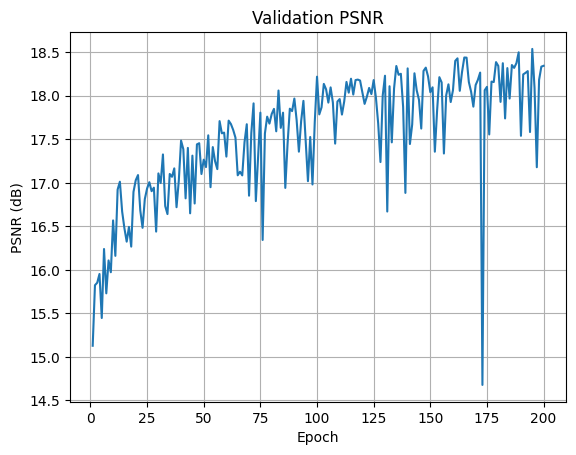

In [27]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('validation_psnr.png', dpi=300, bbox_inches='tight')

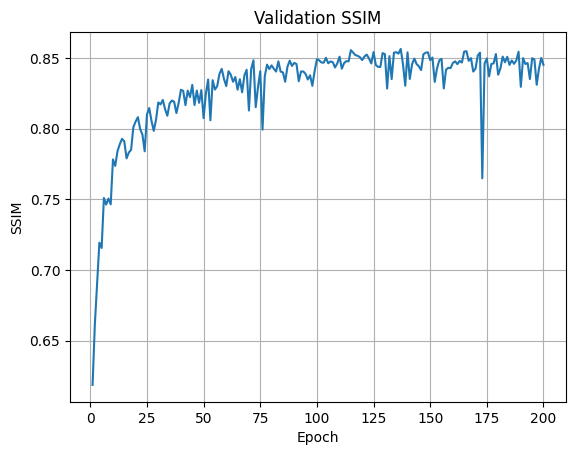

In [28]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('validation_ssim.png', dpi=300, bbox_inches='tight')

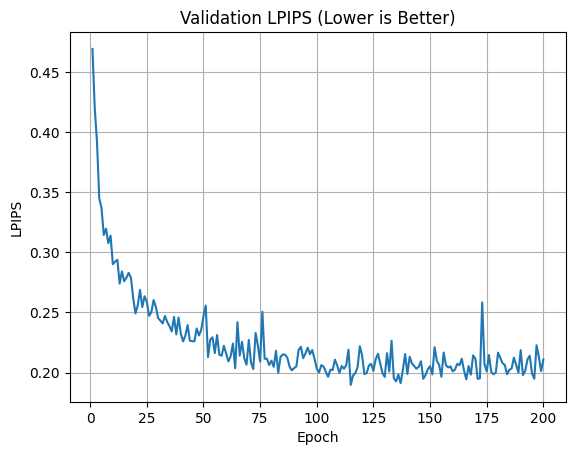

In [29]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('validation_lpips.png', dpi=300, bbox_inches='tight')

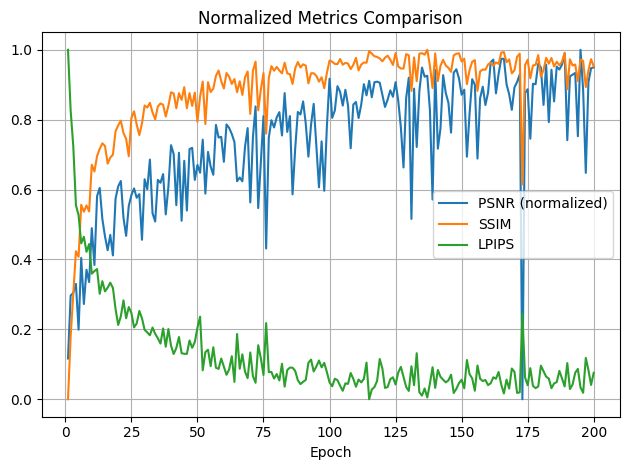

In [30]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend(loc='right')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()